In [1]:
import pickle
import numpy as np

In [2]:
with open("train_qa.txt", "rb") as fp:
    train_data = pickle.load(fp)

In [3]:
with open("test_qa.txt", "rb") as fp:
    test_data = pickle.load(fp)

In [4]:
vocab = set()

In [5]:
all_data = test_data + train_data

In [6]:
for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [7]:
vocab.add("yes")
vocab.add("no")

In [8]:
max_story_len = max([len(data[0]) for data in all_data])

In [9]:
max_ques_len = max([len(data[1]) for data in all_data])

In [10]:
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

In [11]:
tokenizer = Tokenizer(filters = [])

In [12]:
tokenizer.fit_on_texts(vocab)

In [13]:
train_story_text = []
train_question_text = []
train_answers = []

for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [14]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [15]:
def vectorize_stories(data, word_index = tokenizer.word_index, max_story_len = max_story_len, max_ques_len = max_ques_len):
    X = []
    Xq = []
    Y = []

    for story, ques, ans in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in ques]
        y = np.zeros(len(word_index) + 1)
        y[word_index[ans]] = 1

        X.append(x)
        Xq.append(xq)
        Y.append(y)

    return(pad_sequences(X, maxlen = max_story_len), pad_sequences(Xq, maxlen = max_ques_len), np.array(Y))

In [16]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [17]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [18]:
vocab_len = len(vocab) + 1

In [19]:
from keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

In [20]:
input_sequence = Input((max_story_len,))
question = Input((max_ques_len,))

In [21]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim = vocab_len, output_dim = 64))
input_encoder_m.add(Dropout(0.3))

In [22]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim = vocab_len, output_dim = max_ques_len))
input_encoder_c.add(Dropout(0.3))

In [23]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim = vocab_len, output_dim = 64, input_length = max_ques_len))
question_encoder.add(Dropout(0.3))

In [24]:
input_encoded_m = input_encoder_m(input_sequence)

input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [25]:
match = dot([input_encoded_m, question_encoded], axes = (2, 2))
match = Activation('softmax')(match)

In [26]:
response = add([match, input_encoded_c])
response = Permute((2, 1))(response)

In [27]:
answer = concatenate([response, question_encoded])

In [28]:
answer = LSTM(32)(answer)

In [29]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_len)(answer)

In [30]:
answer = Activation('softmax')(answer)

In [31]:
model = Model([input_sequence, question], answer)
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [33]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size = 30, epochs = 22, validation_data = ([inputs_test, queries_test], answers_test))

Epoch 1/22
334/334 [==============================] - 3s 6ms/step - loss: 0.9135 - accuracy: 0.4966 - val_loss: 0.6965 - val_accuracy: 0.4970
Epoch 2/22
334/334 [==============================] - 2s 5ms/step - loss: 0.7062 - accuracy: 0.4995 - val_loss: 0.6935 - val_accuracy: 0.5030
Epoch 3/22
334/334 [==============================] - 2s 5ms/step - loss: 0.6983 - accuracy: 0.4969 - val_loss: 0.6937 - val_accuracy: 0.4970
Epoch 4/22
334/334 [==============================] - 2s 5ms/step - loss: 0.6964 - accuracy: 0.4991 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 5/22
334/334 [==============================] - 2s 5ms/step - loss: 0.6961 - accuracy: 0.5008 - val_loss: 0.6946 - val_accuracy: 0.5030
Epoch 6/22
334/334 [==============================] - 2s 5ms/step - loss: 0.6950 - accuracy: 0.5017 - val_loss: 0.6946 - val_accuracy: 0.5030
Epoch 7/22
334/334 [==============================] - 2s 5ms/step - loss: 0.6954 - accuracy: 0.4977 - val_loss: 0.6975 - val_accuracy: 0.4970
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 0, 'epochs')

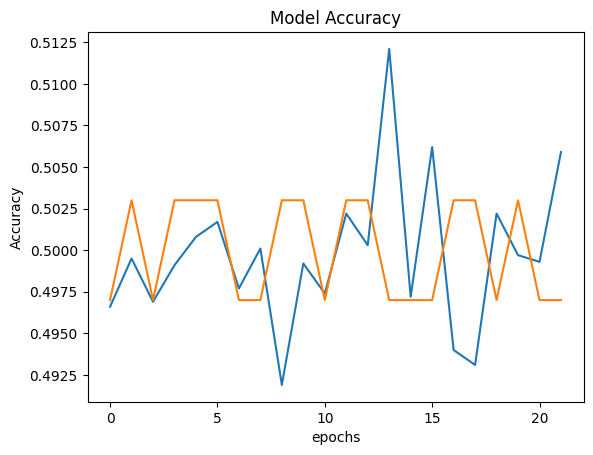

In [34]:
import matplotlib.pyplot as plt

print(history.history.keys())
plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epochs")

In [35]:
model.save("chatbot_model")

INFO:tensorflow:Assets written to: chatbot_model\assets


INFO:tensorflow:Assets written to: chatbot_model\assets


In [36]:
model.load_weights("chatbot_model")

In [37]:
pred_results = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 0s 2ms/step


In [38]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [39]:
story = ' '.join(word for word in test_data[100][0])

In [40]:
story

'John took the apple there . John went to the bathroom .'

In [41]:
query = ' '.join(word for word in test_data[100][1])

In [42]:
query

'Is John in the hallway ?'

In [43]:
test_data[100][2]

'no'

In [44]:
val_max = np.argmax(pred_results[37])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is", k)
print("Probability of certainty", pred_results[37][val_max])

Predicted answer is yes
Probability of certainty 0.5181043
